# Hidden Markov Models

In [27]:
# custom library with some pre-coded functions
!wget -q https://raw.githubusercontent.com/bambschool/BAMB2025/main/Day_4_latent_variable_models/hmm_library.py

zsh:1: command not found: wget


In [1]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo
import scipy.special as scsp

import matplotlib.pyplot as plt
import seaborn as sns

# custom library with some pre-coded functions
import hmm_library as hmmlib

## Tutorial content

1. generative hidden Markov model: simulate data
2. EM for Hidden Markov models

*Note*: You can find many parts of the code pre-coded in the accompanying `hmm_library.py`.

# 0. Intro

As in the previous tutorial, we simulate saccade data. We will now assume that the value of objects, hidden to subjects, fluctuates throughout the experiment as follows:

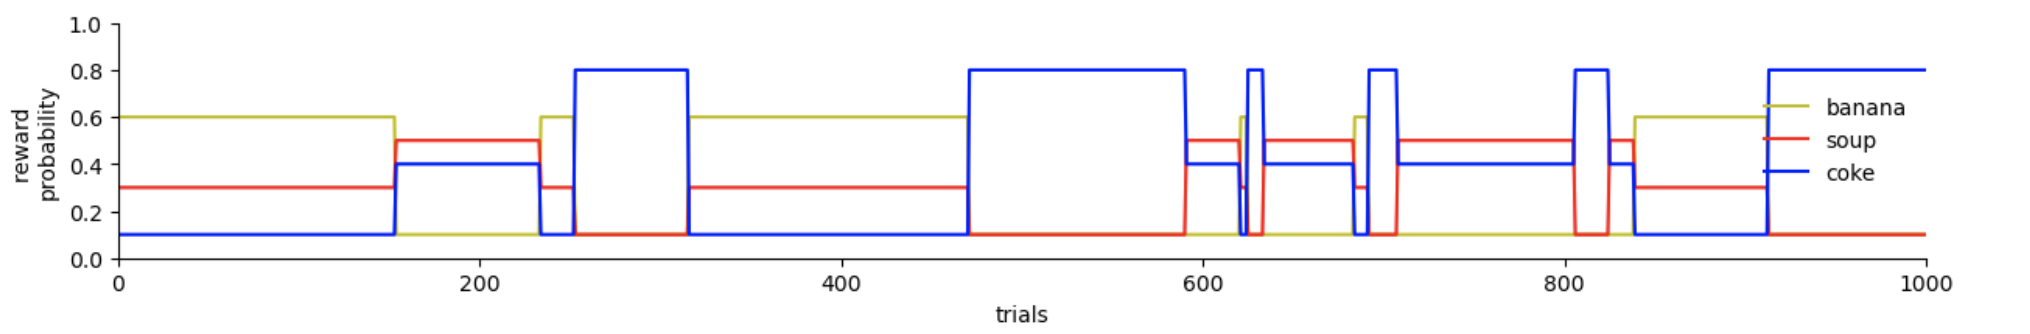

We assume that subjects "track" these values, i.e. that they prefer one item for a few trials, then switch to another item, etc. Hence, saccade endpoints will be dependent between trials.
To obtain insight into the subject's value inference, we will model the temporal dependency between trials explicitly using *hidden Markov models*. 

# 1. The Markov model as a generative model

We can understand Markov models as an extension of mixture models, where sample $n$ depends on sample $n-1$ (e.g. the previous trial). Like mixture models, Markov models have two classes of variables:

- **Latent variables** $\boldsymbol{z} \in \{0, 1\}^{K \times N}$, indicating the class of each sample. In HMMs, $\boldsymbol{z}$ is often called *state*.
- **Observations** $\boldsymbol{x}$, here $\boldsymbol{x} \in \mathbb{R}^{D \times N}$ (but observations could also be categorical). In HMMs, $\boldsymbol{x}$ are also called *emissions*. We will model Gaussian emissions $\boldsymbol{x} | \boldsymbol{z} \sim \mathcal{N}(\mu, \Sigma)$.

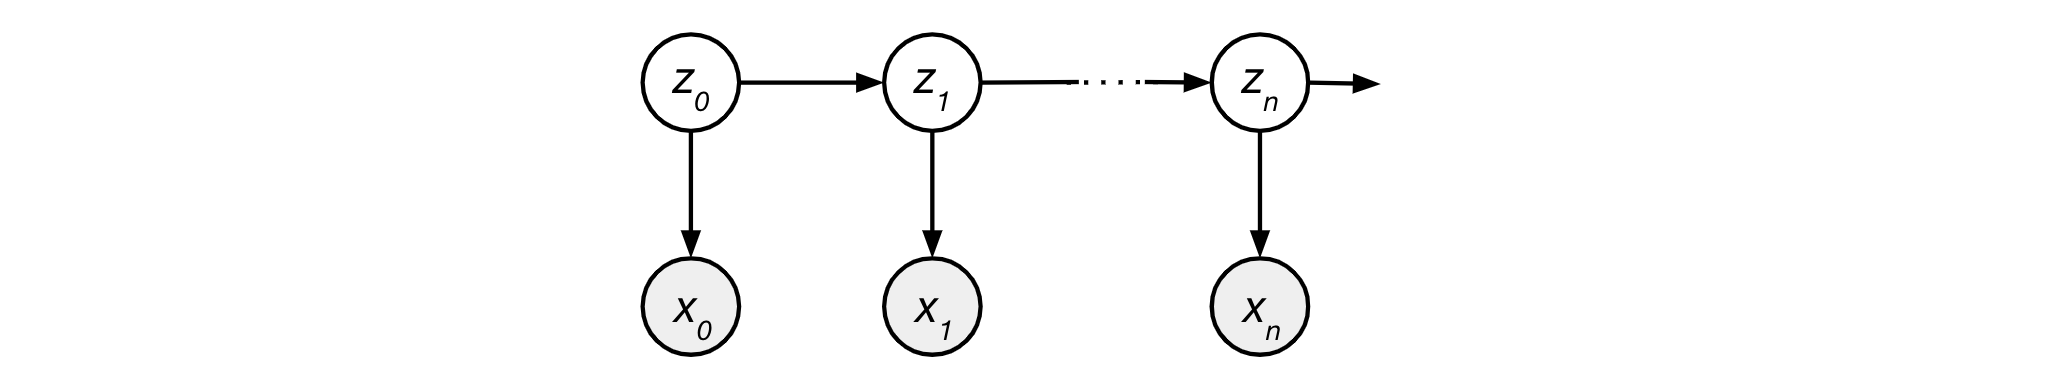

The sequential interdependency of latent variables is jointly described as a *Markov chain*

\begin{align}
p(\boldsymbol{z}_0, ..., \boldsymbol{z}_N) = p(\boldsymbol{z}_0) \prod_{n=1}^{N} p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1})
\end{align}

The joint distribution of latent and observed variables is

\begin{align}
p(\boldsymbol{x}, \boldsymbol{z} | \theta) = p(\boldsymbol{x}_0, ..., \boldsymbol{x}_N, \boldsymbol{z}_0, ..., \boldsymbol{z}_N | \theta) = p(\boldsymbol{z}_0 | \theta) \prod_{n=1}^{N} p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}, \theta) \prod_{n=0}^{N} p(\boldsymbol{x}_n | \boldsymbol{z}_{n}, \theta)
\end{align}<div style="text-align: right"> Eq. (1) </div>

where 
- $p(\boldsymbol{x}_n | \boldsymbol{z}_n, \theta)$ are the *emission probabilities*, i.e. the likelihood that $\boldsymbol{x}_n$ was sampled from state $k$ encoded in $\boldsymbol{z}_n$ 
- $p(\boldsymbol{z}_0 | \theta)$ a vector of $k$ *initial state probabilities*, parametrized by $\pi_k$, 
- and $p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}, \theta)$ the *transition probabilities* between states in two adjacent samples. Since we need to know the probability to transition from any of $k$ states into any other state, transition probabilities are parametrized by a matrix $\boldsymbol{A} \in [0,1]^{K \times K}$, with $A_{jk} = p(z_{n,k}=1 | z_{n-1,j}=1)$ (rows sum to 1).

Sample an artificial dataset of 1000 trials from Eq. (1). Hyperparameters $K$ and $D$, as well as $\mu$, $\Sigma$, and $\pi$ are taken to be the same as in the Gaussian mixture model tutorial (but note that $\pi$ now has a slightly different interpretation).

## 1.1. Ground truth parameters 



In [2]:
# set random seed
np.random.seed(0)

# Hyperparameters
N = 1000
K = 3
D = 2

# screen borders
borders = np.array([[0,80], [0,60]])

# initial state probabilities
pis = [.2, .35, .45]

# transition probabilities - normalize rows to sum to 1
As = np.eye(K) + np.random.rand(K,K)/50
As = np.array([a/np.sum(a) for a in As])

# mus
mus = [np.array([20,20]), np.array([35,40]), np.array([60,25])]

# pick covariances - make symmetric with small covariance to ensure they are positive semidefinite
sigmas = [20*np.array([[1,-.4],[-.4,1]]), 
          40*np.array([[.5,0],[0,1]]), 
          40*np.array([[1,.1],[.1,1]])]

## 1.2. True value of latent variable $\boldsymbol{z}$

Write a loop to sample $\boldsymbol{z}$. Choose $z_n$ based on $z_{n-1}$ based on transition probabilities in $A$.

In [3]:
# sample initial state
ks = [np.random.choice(K, p=pis)]

# sample state sequence in a loop, with probabilities taken from row k of matrix A
for n in range(N-1):
    ks_new = np.random.choice(K, p=As[ks[n]])
    ks.append(ks_new)

ks = np.array(ks)

# make K x N array for true values of z
z_values = [[1,0,0], [0,1,0], [0,0,1]]
zs = np.array([z_values[k] for k in ks]).T

Plot the sequence of states over time.

Text(0.5, 0, 'trial')

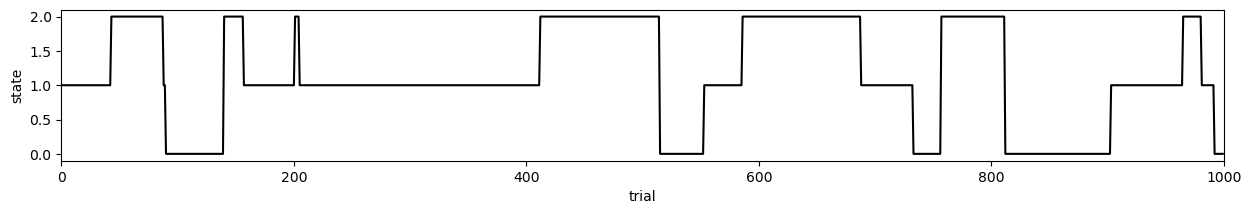

In [4]:
plt.figure(figsize=(15,2), dpi=100)
plt.plot(ks, 'k-')
plt.xlim(0,N)
plt.ylabel('state')
plt.xlabel('trial')

## 1.3. Sample observations $\boldsymbol{x}$

Sample observations $\boldsymbol{x}$ from a multivariate Gaussian as in the previous tutorial. Uncomment the respective lines to plot saccade data across trials in the 2D space of observations.

In [5]:
# simulate saccades depending on k_n
saccades = np.array([sps.multivariate_normal.rvs(mus[ks[n]], sigmas[ks[n]], 1) for n in range(N)])

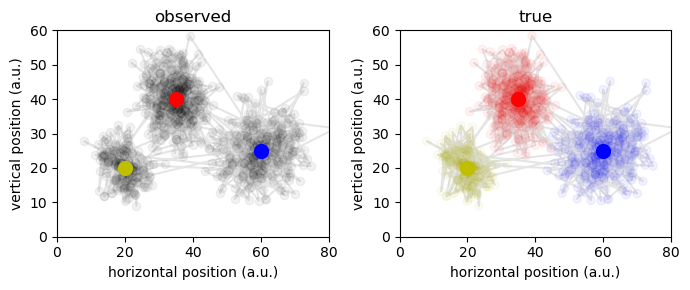

In [6]:
# plot data
colors = ['y', 'r', 'b']

plt.figure(figsize=(7,3), dpi=100)
plt.subplot(1,2,1)
plt.scatter(saccades[:,0], saccades[:,1], c='k', alpha=.05)
plt.plot(saccades[:,0], saccades[:,1], 'k-', alpha=.1)
for mi,m in enumerate(mus):
    plt.plot(m[0], m[1], 'o', color=colors[mi], ms=10)
plt.xlim(borders[0])
plt.ylim(borders[1])
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.title('observed')

plt.subplot(1,2,2)
plt.scatter(saccades[:,0], saccades[:,1], c=[colors[k] for k in ks], alpha=.05)
plt.plot(saccades[:,0], saccades[:,1], 'k-', alpha=.1)
for mi,m in enumerate(mus):
    plt.plot(m[0], m[1], 'o', color=colors[mi], ms=10)
plt.xlim(borders[0])
plt.ylim(borders[1])
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.title('true')
plt.tight_layout()

# 2. Fitting hidden Markov models with EM

To the experimenter, the values of the latent variable $\boldsymbol{z}$ are unobserved or *hidden* - this is how a Markov model becomes a hidden Markov model.

Our inference problem concerns:
- the value of the hidden variable, $z_n$, for observation $x_n$
- parameters $\theta = \{\mu, \Sigma, \pi, \boldsymbol{A}\}$.

We will use the EM algorithm to iteratively infer posteriors over $\boldsymbol{z}$ and the parameters $\theta$. The E step is more complicated than in mixture models, due to the sequential dependency of $\boldsymbol{z}$.

## 2.1. Initialization

Write a function to pick random values for the parameters (within sensible bounds; you can re-use code from the previous tutorial). 

Initialize $\boldsymbol{A}$ as a $K \times K$ identity matrix and add some noise. Keep in mind that all elements $A_{jk}\ge 0$. Normalize rows of $\boldsymbol{A}$ as well as the initial state probabilities $\pi$.

In [7]:
# function to initialize the HMM
def initialize_HMM(K, D, lower, higher, seed):
    
    np.random.seed(seed)
    
    # mu: initialize means to random integers
    m = np.random.randint(low=lower, high=higher, size=(K, D))
    
    # Sigma: initialize covariance to random integer on diagonal, 0 off-diagonal
    s = np.array([np.eye(D)*np.random.randint(low=np.max(higher)/4, high=np.max(higher)) 
                  for i in range(K)])
    
    # pi: pick random numbers that sum to 1
    p = np.random.rand(K)
    p/= np.sum(p)
    
    # A: Identity plus random numbers, rows should sum to 1
    A = np.eye(K) + np.random.rand(K,K)/10
    A = np.array([a/sum(a) for a in A])
    
    return m, s, p, A

In [8]:
# call initialization
m, s, p, A = initialize_HMM(K, D, lower=0, higher=80, seed=0)

## 2.2. Evaluation of log likelihoods

The likelihood $p(\boldsymbol{x}_n | z_{nk}=1, \theta)$ tells us how likely each sample is under a class- (or state-)specific model. We have used it in the mixture model tutorial (in the E Step, as well as for the evaluation of the expected complete-data log likelihood), but we have never visualized what it tells us about the data.

Evaluate the log likelihood $\ln p(\boldsymbol{x}_n | z_{nk}=1, \theta)$ for each sample $n$. The resulting array should have shape $K \times N$: It encodes the likelihood of sample $n$ belonging to state $k$. 

Use the pre-coded plotting function to plot the probability density for each state, as well as the observations, color-coded by the log likelihood.

In [9]:
# evaluate log likelihood for each datapoint
log_likes = np.array([sps.multivariate_normal.logpdf(saccades, m[k], s[k])
                    for k in range(K)])

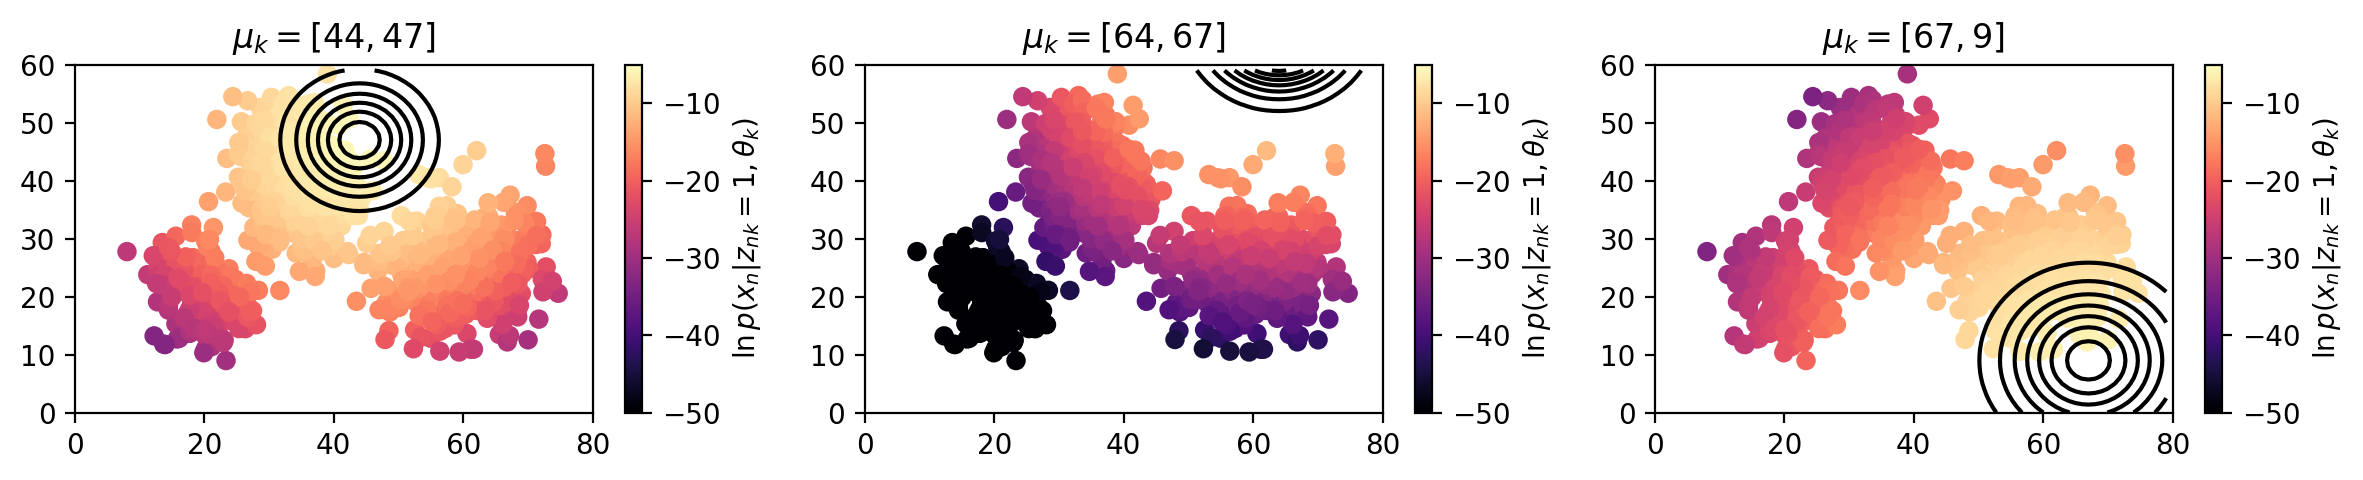

In [10]:
# make 2D meshgrid
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate pdf at grid 
pdfs = [sps.multivariate_normal.pdf(vals, m[k], s[k])
        for k in range(K)]

plt.figure(figsize=(12,2.5), dpi=200)
for k in range(K):
    plt.subplot(1,3,k+1)
    plt.contour(pdfs[k].T, colors='k')
    plt.scatter(saccades[:,0], saccades[:,1], c=log_likes[k], cmap='magma', vmin=-50, vmax=-5)
    plt.title(r'$\mu_k = [%.0f, %.0f]$' %(m[k][0], m[k][1]))
    plt.xlim(0,80)
    plt.ylim(0,60)
    plt.colorbar(label= r'$\ln p(x_n | z_{nk}=1, \theta_k)$')
plt.tight_layout()

## 2.3. E Step

As in the last tutorial, we want to infer posterior distributions of the latent variable, which are then used to maximize the expected complete-data log likelihood in the M Step. Since $\boldsymbol{z}$ is *not i.i.d.*, but has temporal interdependencies (see graph and Eq. (1)), two posteriors are of interest: 
- The probability of observing state $k$ at trial $n$, $\gamma(z_{nk})$
- the probability of observing state $k$ in trial $n$, after having observed state $j$ in trial $n-1$, $\xi(z_{n-1,j},z_{nk})$.

### 2.3.1. Marginal posterior $\gamma$

We can use Bayes theorem to calculate the marginal posterior $\gamma(z_n) = p(\boldsymbol{z}_n | \boldsymbol{x}, \theta)$ (dropping $\theta$ to keep this uncluttered):

\begin{align}
p(\boldsymbol{z}_n | \boldsymbol{x}) &= \frac{p(\boldsymbol{x} | \boldsymbol{z}_n) p(\boldsymbol{z}_n)}{p(\boldsymbol{x})} \\
&= \frac{p(\boldsymbol{x}_{0:n} | \boldsymbol{z}_n) p(\boldsymbol{x}_{n+1:N} | \boldsymbol{z}_n) p(\boldsymbol{z}_n)}{p(\boldsymbol{x})} \\
\end{align} 

where we separate $p(\boldsymbol{x} | \boldsymbol{z}_n)$ into two terms, $p(\boldsymbol{x}_{0:n} | \boldsymbol{z}_n)$ and $p(\boldsymbol{x}_{n+1:N} | \boldsymbol{z}_n)$. We can do this because observations $\boldsymbol{x}_{0:n}$ and $\boldsymbol{x}_{n+1:N}$ are conditionally independent, given $\boldsymbol{z}_{n}$, as shown in this graph: 

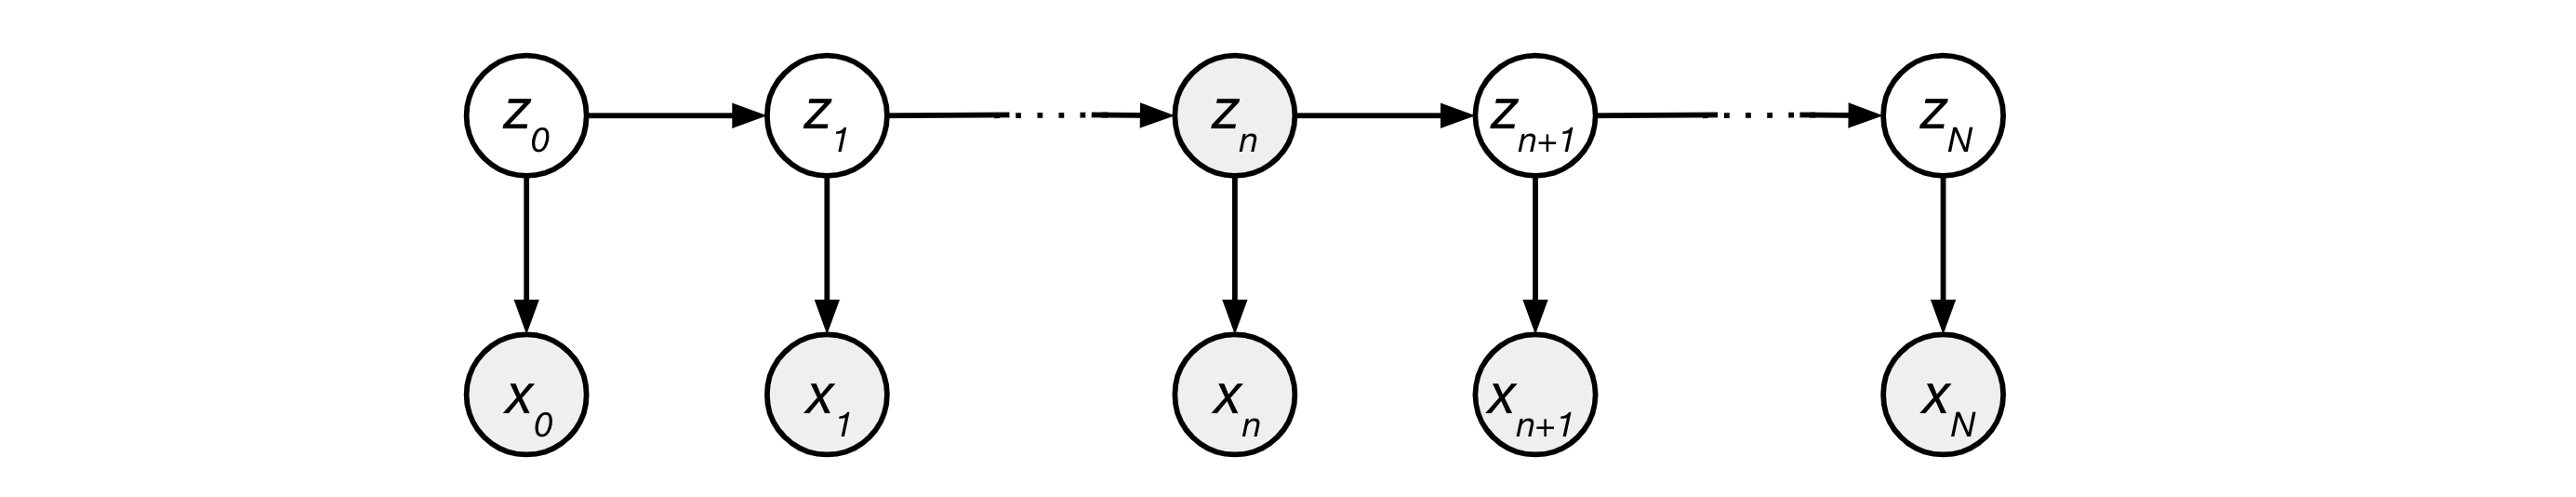

Moreover, we introduce *forward messages* $\alpha(\boldsymbol{z}_n) = p(\boldsymbol{x}_{0:n} | \boldsymbol{z}_n) p(\boldsymbol{z}_n) = p(\boldsymbol{x}_{0:n}, \boldsymbol{z}_n)$ and *backward messages* $\beta(\boldsymbol{z}_n) = p(\boldsymbol{x}_{n+1:N} | \boldsymbol{z}_n)$, so that:

\begin{align}
p(\boldsymbol{z}_n | \boldsymbol{x}) &= \frac{\alpha(\boldsymbol{z}_n) \beta(\boldsymbol{z}_n)}{p(\boldsymbol{x})} 
\end{align} <div style="text-align: right"> Eq. (2) </div>

### 2.3.2. Joint posterior $\xi$

Similarly, we can calculate the joint posterior $\xi(z_n,z_{n-1}) = p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_n | \boldsymbol{x}, \theta)$ (again omitting $\theta$ and skipping intermediate steps of the derivation):

\begin{align}
p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_n | \boldsymbol{x}) &= \frac{p(\boldsymbol{x} | \boldsymbol{z}_{n-1}, \boldsymbol{z}_{n}) p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_{n})}{p(\boldsymbol{x})} \\
&= \frac{\alpha(\boldsymbol{z}_{n-1}) p(\boldsymbol{x}_n | \boldsymbol{z}_n) p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}) \beta(\boldsymbol{z}_n)}{p(\boldsymbol{x})} 
\end{align} <div style="text-align: right"> Eq. (3) </div>

To calculate $\alpha(\boldsymbol{z}_n)$ and $\beta(\boldsymbol{z}_n)$, we use a recurrent algorithm, called the *forward-backward algorithm* (also called Baum-Welch algorithm).

### 2.3.3. Forward-backward algorithm

*Forward messages* $\alpha(\boldsymbol{z}_n) = p(\boldsymbol{x}_{0:n}, \boldsymbol{z}_n)$ tell us for each trial $n$ the probability of being in state $\boldsymbol{z}_n$, given all obervations $\boldsymbol{x}_{0:n}$ up tp $n$. *Backward messages* $\beta(\boldsymbol{z}_n) = p(\boldsymbol{x}_{n+1:N} | \boldsymbol{z}_n)$ look ahead in time: What would be the probability of *future* observations $\boldsymbol{x}_{n+1:N}$, if we started from each of the states $\boldsymbol{z}_n$ in trial $n$?

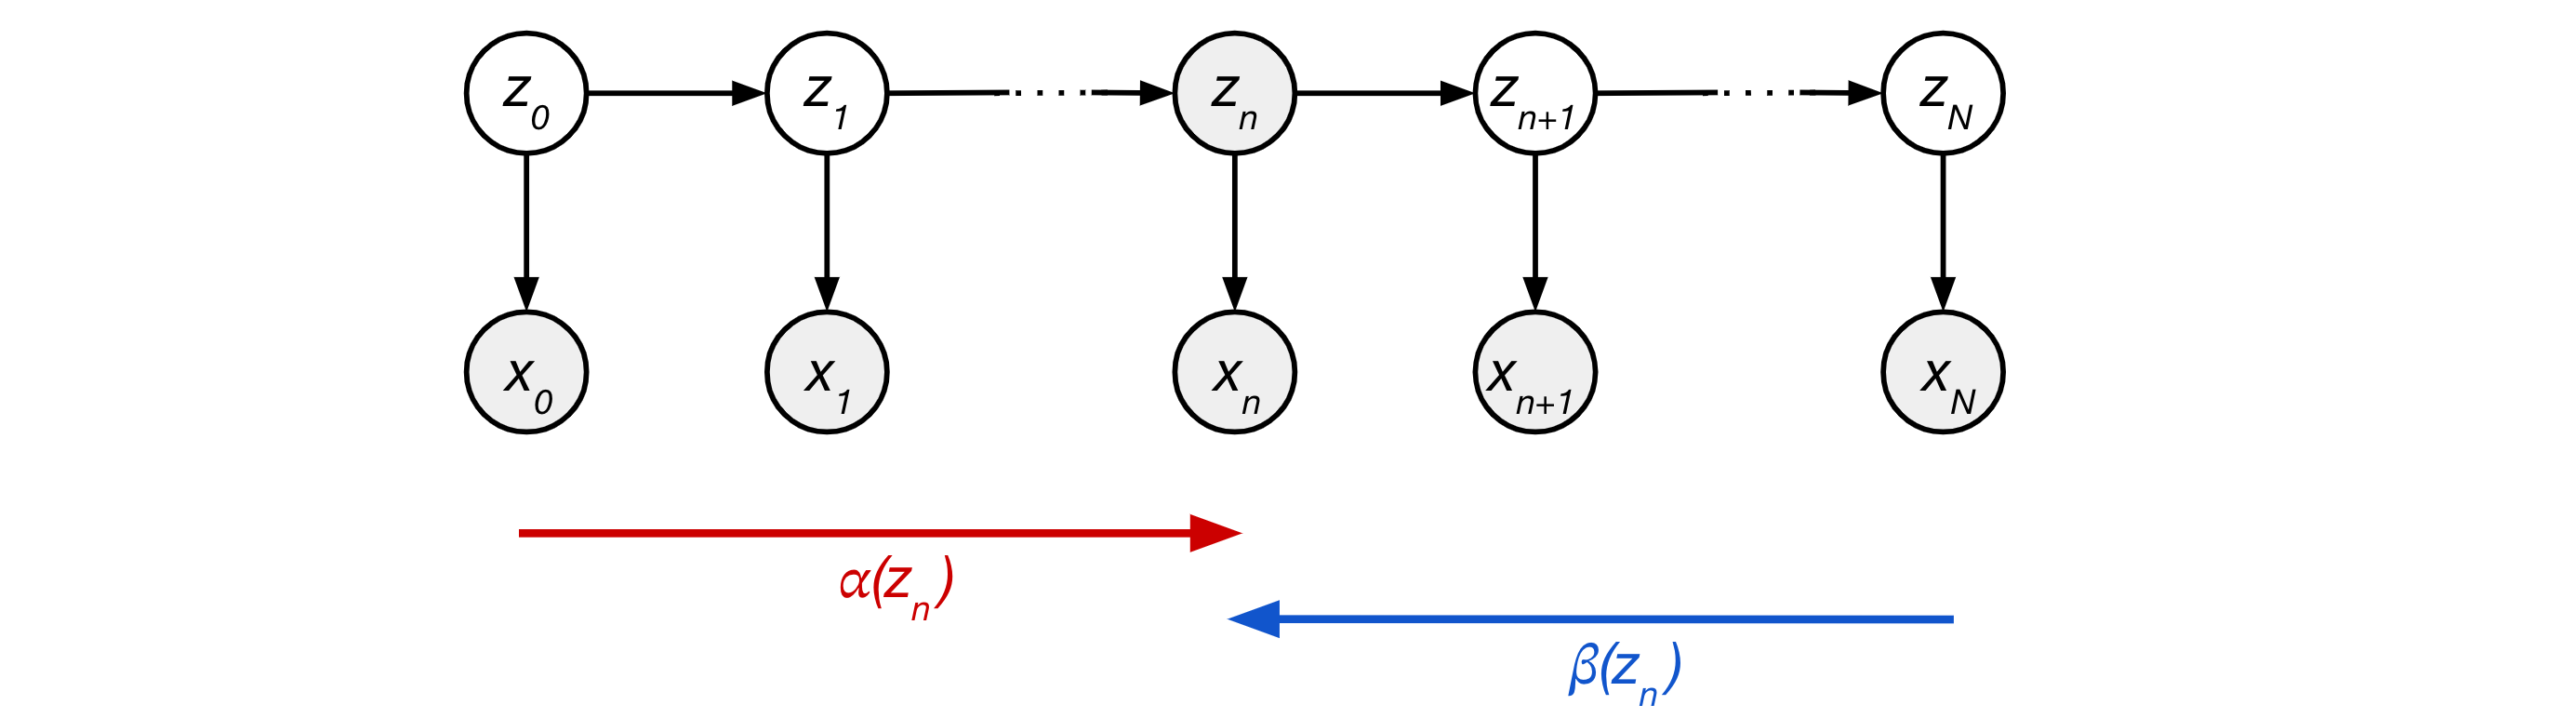

The forward-backward algorithm calculates $\alpha(\boldsymbol{z}_n)$ from $\alpha(\boldsymbol{z}_{n-1})$, and  $\beta(\boldsymbol{z}_n)$ from $\beta(\boldsymbol{z}_{n+1})$.

Hence, we'll have to calculate $\alpha(\boldsymbol{z}_0)$ and $\beta(\boldsymbol{z}_N)$ and then iterate forward or backward in time. For the sake of time, we implemented these equations for you in the `hmm_library`, commenting on what each line does - no need to look at it now.

#### Forward messages

We calculate forward messages as

\begin{align}
\alpha(\boldsymbol{z}_0) &= p(\boldsymbol{z}_0)p(\boldsymbol{x}_0 | \boldsymbol{z}_0)  \\
\alpha(\boldsymbol{z}_n) &= p(\boldsymbol{x}_n | \boldsymbol{z}_n) \sum_{z} \{\alpha(\boldsymbol{z}_{n-1})p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1})\} 
\end{align}

Note that we will again calculate log-transformed values $\ln \alpha(\boldsymbol{z}_n)$, since they are easier to work with. 
Call `log_alphas = hmmlib.forward(p, A, log_likes)` to get log-transformed forward messages.

In [11]:
log_alphas = hmmlib.forward(p, A, log_likes)

#### Backward messages

Then, we call `log_betas = hmmlib.backward(A, log_likes)` to calculate log-transformed backward messages $\ln \beta(\boldsymbol{z}_n)$, where

\begin{align}
\beta(\boldsymbol{z}_N) &= 1 \\
\beta(\boldsymbol{z}_n) &= \sum_{z} \beta(z_{n+1}) p(\boldsymbol{x}_{n+1} | \boldsymbol{z}_{n+1}) p(\boldsymbol{z}_{n+1} | \boldsymbol{z}_n)
\end{align}

The initial value is taken to be 1, so that $p(\boldsymbol{z}_N | \boldsymbol{x}) = \frac{p(\boldsymbol{z}_N, \boldsymbol{x}) \beta(\boldsymbol{z}_N)}{p(\boldsymbol{x})}$ is properly normalized. Call `log_betas = hmmlib.backward(A, log_likes)` to get log-transformed backward messages.

In [12]:
log_betas = hmmlib.backward(A, log_likes)

### 2.3.4. Calculate expected states: marginal posterior $\gamma$

Write a function that implements Eq. (2) to calculate the posterior $\gamma(z_n) = p(\boldsymbol{z}_n | \boldsymbol{x})$ from $\alpha(\boldsymbol{z}_n)$ and $\beta(\boldsymbol{z}_n)$. For reference, here we have Eq. (2) written out in a slightly different way:

\begin{align}
p(\boldsymbol{z}_n | \boldsymbol{x}) 
= \frac{p(\boldsymbol{x} | \boldsymbol{z}_n) p(\boldsymbol{z}_n)}{p(\boldsymbol{x})}
= \frac{{p(\boldsymbol{x}, \boldsymbol{z}_n)}}{\sum_{\boldsymbol{z}} p(\boldsymbol{x}, \boldsymbol{z}_n)} 
= \frac{\alpha(\boldsymbol{z}_n) \beta(\boldsymbol{z}_n)}{\sum_{\boldsymbol{z}} \alpha(\boldsymbol{z}_n) \beta(\boldsymbol{z}_n)} 
\end{align}


<!-- *Hint*: From Eq. (2), we see that we can express the marginal likelihood $p(\boldsymbol{x})$ as the likelihood of observing a sequence up to trial $n$: $p(\boldsymbol{x}_{0:n}) = \sum_z p(\boldsymbol{x}_{0:n}, \boldsymbol{z}_n) = \sum_K \alpha(z_{nk})$. -->

Plot $\gamma(z_{n})$ over trials.

In [13]:
def expected_states(log_alphas, log_betas):

    # upper: alpha * beta --> becomes log_alpha + log_beta
    upper = log_alphas + log_betas
    
    # subtract log of the sum over states of log_alpha + log_beta
    log_gammas = upper - scsp.logsumexp(upper, axis=1, keepdims=True)
    
    # transform back by taking exp
    gammas = np.exp(log_gammas)
    
    return gammas

In [14]:
gammas = expected_states(log_alphas, log_betas)

Text(0.5, 0, 'trial')

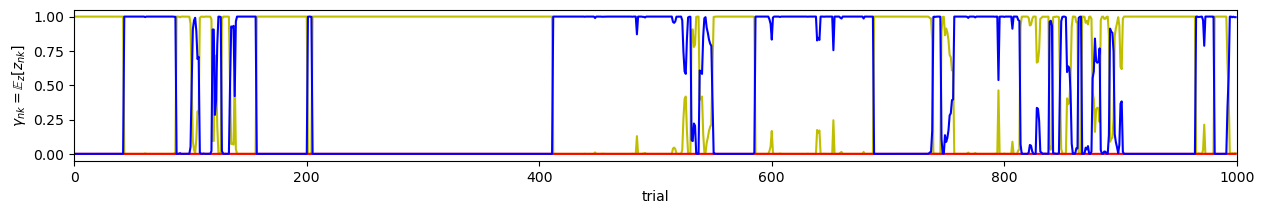

In [15]:
# plot gammas over the course of trials
plt.figure(figsize=(15,2), dpi=100)

for k,g in enumerate(gammas.T):
    plt.plot(g, color=colors[k])
plt.xlim(0,N)
plt.ylabel(r'$\gamma_{nk} = \mathbb{E}_z[z_{nk}]$')
plt.xlabel('trial')

### 2.3.5. Calculate expected transitions: Joint posterior $\xi$

Analogously, we can calculate the joint posterior $\xi(z_n,z_{n-1}) = p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_n | \boldsymbol{x}, \theta)$ from Eq. (3) (again omitting $\theta$):

\begin{align}
p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_n | \boldsymbol{x}) 
= \frac{p(\boldsymbol{x} | \boldsymbol{z}_{n-1}, \boldsymbol{z}_{n}) p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_{n})}{p(\boldsymbol{x})}
= \frac{p(\boldsymbol{x}, \boldsymbol{z}_{n-1}, \boldsymbol{z}_{n})}{\sum_{\boldsymbol{z}_n}\sum_{\boldsymbol{z}_{n-1}} p(\boldsymbol{x}, \boldsymbol{z}_{n-1}, \boldsymbol{z}_{n})} 
= \frac{\alpha(\boldsymbol{z}_{n-1}) p(\boldsymbol{x}_n | \boldsymbol{z}_n) p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}) \beta(\boldsymbol{z}_n)}{\sum_{\boldsymbol{z}_n}\sum_{\boldsymbol{z}_{n-1}} \alpha(\boldsymbol{z}_{n-1}) p(\boldsymbol{x}_n | \boldsymbol{z}_n) p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}) \beta(\boldsymbol{z}_n)} 
\end{align}, 

where $p(\boldsymbol{x}_n | \boldsymbol{z}_n, \theta)$ is the likelihood of $\boldsymbol{x}_n$ under any of the $k$ states encoded by $z_n$, and $p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}, \theta)$ are transition probabilities stored in $\boldsymbol{A}$.

Call `hmmlib.expected_transitions(log_alphas, log_betas, log_likes, A)` to calculate expected values $\xi(z_n,z_{n-1})$ of the joint posterior.

In [16]:
xis = hmmlib.expected_transitions(log_alphas, log_betas, log_likes, A)

### 2.3.6. Full E Step

Write a function `HMM_estep(p, As, log_likes)` that calls `forward`, `backward`, `expected_states` and `expected_transitions` and returns $\gamma(z_{nk}) \in [0,1]^{T \times K}$ and $\xi(z_{n-1,k}, z_{n,j}) \in [0,1]^{T \times K \times K}$, as well as the log likelihood.

***Hint:*** In hidden Markov models, the likelihood $p(\boldsymbol{x}) = p(\boldsymbol{x}_N)$ comes for free from the forward-backward algorithm. Eq. (2) as written out in section 2.3.4. will tell you how to calculate it.

In [17]:
def HMM_estep(p, As, log_likes):
    
    # forward pass
    alphas = hmmlib.forward(p, A, log_likes)
    
    # backward pass
    betas = hmmlib.backward(A, log_likes)
    
    # calculate posterior: expected states
    gammas = expected_states(alphas, betas)
    
    # calculate posterior: expected transitions
    xis = hmmlib.expected_transitions(alphas, betas, log_likes, As)
    
    # calculate log likelihood
    log_LL = np.sum(alphas[-1] + betas[-1])
    
    return gammas, xis, log_LL

In [18]:
gammas, xis, log_LL = HMM_estep(p, A, log_likes)

## 3. M Step

Good news: the M Step is more straightforward.

As in the previous tutorial, it consists of plugging in $\gamma(z_{nk})$ and $\xi(z_{n-1,k}, z_{nj})$ in the expected complete-data log likelihood $\mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)]$ from Eq. (1). We then derive it w.r.t. each of the model parameters $\theta = \{\mu, \Sigma, \pi, A\}$ (we'll spare you the math excercise). Setting these derivatives to zero leads to closed-form solutions for ML parameter updates as in the mixture model tutorial.

The resulting solutions for each of the parameters are:

\begin{align}
\mu_k &= \frac{\sum_N \gamma(z_{nk})\boldsymbol{x}_n}{\sum_N \gamma(z_{nk})} \\
\end{align}<div style="text-align: right"> Eq. (4) </div>
\begin{align}
\Sigma_k &= \frac{\sum_N \gamma(z_{nk})(\boldsymbol{x}_n -\mu_k)(\boldsymbol{x}_n -\mu_k)^T}{\sum_N\gamma(z_{nk})} \\
\end{align}<div style="text-align: right"> Eq. (5) </div>
\begin{align}
\pi_k = \frac{\gamma(z_{0,k})}{\sum_K \gamma(z_{0,j})}
\end{align}<div style="text-align: right"> Eq. (6) </div>
\begin{align}
A_{jk} = \frac{\sum_N \xi(z_{n-1,j}, z_{nk})}{\sum_K \sum_N \xi(z_{n-1,j}, z_{nl})}
\end{align}<div style="text-align: right"> Eq. (7) </div>

Write a function `HMM_mstep(data, gammas, xis)` that implements Eqs. (4-7) and returns the updated parameters. If you are stuck, look at the M step as pre-coded in the library.

In [19]:
def HMM_mstep(data, gammas, xis):
    K = gammas.shape[1]
    N = gammas.shape[0]
    D = data.shape[-1]
    
    # class-specific normalization constant
    Nk = np.sum(gammas, axis=0)
    
    # mu
    m = np.array([np.sum(gammas[:,k][:,np.newaxis]*data, axis=0)/Nk[k] for k in range(K)])
    
    # Sigma
    s = np.zeros([K,D,D]) * np.nan
    for k in range(K):
        summation = 0
        for n in range(N):
            summation += gammas[n,k] * (data[n]-m[k])[:,np.newaxis] @ (data[n]-m[k])[:,np.newaxis].T
        s[k,:,:] = summation/Nk[k] 
        
        # in case that only one data point is assigned to a class, we get zero variance
        # reset cov matrix
        if Nk[k]<2:
            s[k,:,:] = np.eye(D) * 100
    
    # pi
    p = gammas[0]/np.sum(gammas[0])
    
    # A
    A = np.sum(xis[1:], axis=0)  # shape: [K, K]
    A = A / A.sum(axis=1, keepdims=True)  # normalize rows so that they are valid distributions

    return m, s, p, A

In [20]:
# call M step
m_new, s_new, p_new, A_new = HMM_mstep(saccades, gammas, xis)

## 4. full EM for hidden Markov models

We now have all code elements to run a full iteration of EM for the HMM. Write a code that 0) initializes parameters $\theta = \{\mu, \Sigma, \pi, A\}$, 1) performs the E Step and then 2) the M Step. Iterate over 1) and 2) 50 times. 

Repeat the procedure with 5 different random initializations. Save log likelihoods and model parameters for each repetition and pick the best model.

In [21]:
model = []; LLs = []

# iterate 5 times
for iter in range(5):
    print(iter)
    
    LL = []

    # 0: initialization
    m, s, p, A = initialize_HMM(K, D, lower=0, higher=80, seed=iter)

    for i in range(50):

        # evaluate log likelihoods 
        log_likes = np.array([sps.multivariate_normal.logpdf(saccades, m[k], s[k])
                            for k in range(K)])

        # 1: E Step
        gammas, xis, log_LL = HMM_estep(p, A, log_likes)

        # 2: M step
        m, s, p, A = HMM_mstep(saccades, gammas, xis)

        LL.append(log_LL)

    model.append([m, s, p, A])
    LLs.append(LL)

0


/Users/heike/Downloads/BAMB2024-main 2/Day 4: Latent variable models/hmm_library.py:28: RuntimeWarning: divide by zero encountered in log
  alphas = [np.log(p) + log_likes[:,0]]


1
2
3
4


## 4.1. Learning curves

Plot likelihood curves over learning to check model convergence.

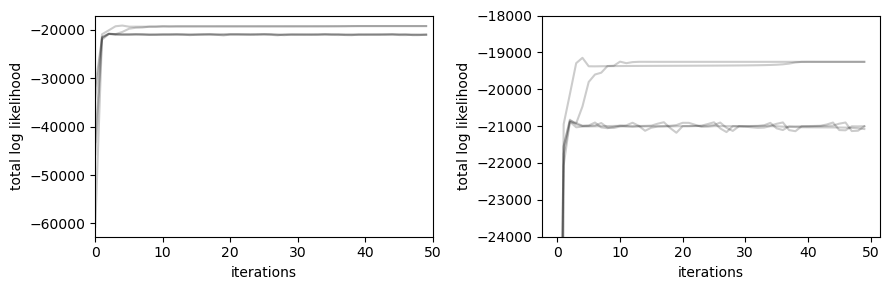

In [22]:
# plot log likelihoods for all random initializations to check if model converged
plt.figure(figsize=(9,3), dpi=100)
plt.subplot(1,2,1)
plt.plot(np.array(LLs).T, 'k-', alpha=.2)
plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,50)
plt.subplot(1,2,2)
plt.plot(np.array(LLs).T, 'k-', alpha=.2)
plt.xlabel('iterations')
plt.ylabel('total log likelihood')
# plt.xlim(0,20)
plt.ylim(-24000, -18000)
plt.tight_layout()

## 4.2. Visualize best model

Pick the best model and plot the Gaussian distribution for each of the three states. Compare (qualitatively) to the ground truth. 

In [23]:
# select best model
best_model = np.argmax([ll[-1] for ll in LLs])
m, s, p, A = model[best_model]

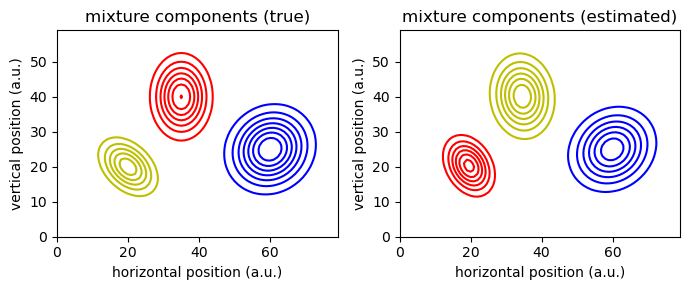

In [24]:
# plot final means and covariances, as well as final mixture distribution

# make 2D meshgrid
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate pdfs
pdfs = [sps.multivariate_normal.pdf(vals, m[k], s[k]) for k in range(K)]

# true pdfs
pdfs_true = [sps.multivariate_normal.pdf(vals, mus[k], sigmas[k]) for k in range(K)]

plt.figure(figsize=(7,3), dpi=100)
plt.subplot(1,2,1)
for k,pdf in enumerate(pdfs_true):
    plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components (true)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,2,2)
for k,pdf in enumerate(pdfs):
    plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components (estimated)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.tight_layout()

# 3. Decoding the optimal sequence: Viterbi algorithm

In the hidden Markov model, we are often interested in classifying data points as belonging to one state or another. In our example, we would like to know which object a subject was looking at in each trial. Since $\boldsymbol{z}$ is connected in time, we cannot just pick the state with the highest $\gamma\boldsymbol(z)_{nk}$ for each trial, but have to consider the whole sequence of states together.

Since from each state $k_n$, we can go to any state $k_{n+1}$, and from there to any other state $k_{n+2}$ and so forth, there will be $K \times K \times  K ...$, i.e., $K^N$, potential sequences.

The *Viterbi algorithm* is a smart way of tackling this problem iteratively: It will determine the most likely state in each trial $n$, based on a combination of the likelihood $p(\boldsymbol{x}_n | \boldsymbol{x}_n, \theta)$, the most likely state in trial $n-1$, and the transition probabilities from trial $n-1$ to trial $n$.

We have pre-coded the Viterbi algorithm for you. It works with log probabilities, and will return a sequence of values that you can directly compare to the ground truth sequence of `ks`. 

Evaluate the log likelihoods under the best model, and pass it to `hmmlib.log_viterbi(log_likes, A, p)`, together with $A$ and $\pi$. Plot the fitted sequence vs. the true sequence of states.

In [25]:
# evalualte log likelihoods under the best model
log_likes = np.array([sps.multivariate_normal.logpdf(saccades, m[k], s[k])
                            for k in range(K)])

# call log viterbi
seq = hmmlib.log_viterbi(log_likes, A, p)

/Users/heike/Downloads/BAMB2024-main 2/Day 4: Latent variable models/hmm_library.py:189: RuntimeWarning: divide by zero encountered in log
  deltas[:,0] = np.log(p) + log_likes[:,0]


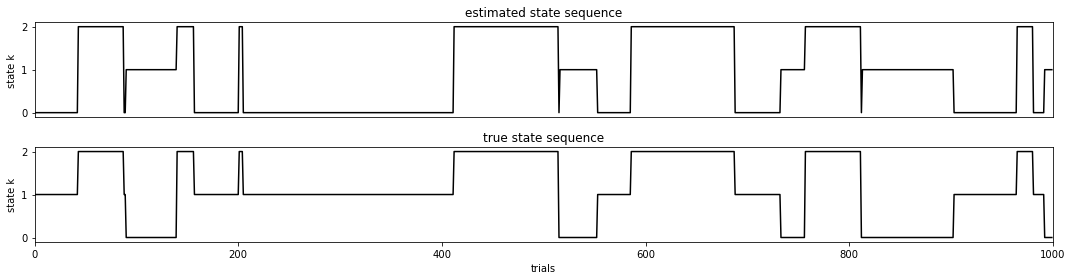

In [26]:
plt.figure(figsize=(15,4))
plt.subplot(2,1,1)
plt.plot(seq, 'k')
plt.title('estimated state sequence')
plt.xlim(0,1000)
plt.xticks([])
plt.ylabel('state k')
plt.subplot(2,1,2)
plt.plot(ks, 'k', label='true')
plt.title('true state sequence')
plt.xlim(0,1000)
plt.xlabel('trials')
plt.ylabel('state k')
plt.tight_layout()